<a href="https://colab.research.google.com/github/Harshit052610/fair-rlhf-code/blob/main/evaluate_fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

Saving preprocessed_shopping_data.csv to preprocessed_shopping_data.csv
Preprocessed data loaded from 'preprocessed_shopping_data.csv' with shape: (3900, 107)
Model loaded successfully.

Recommendation distribution by Gender:
Gender_Male
Female    {'Footwear': 0.5448717948717948, 'Outerwear': ...
Male      {'Footwear': 0.8103318250377074, 'Outerwear': ...
Name: recommendation_proportion, dtype: object

Demographic Parity Difference for 'Clothing' recommendations: 0.022
(Lower values indicate better fairness across groups)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

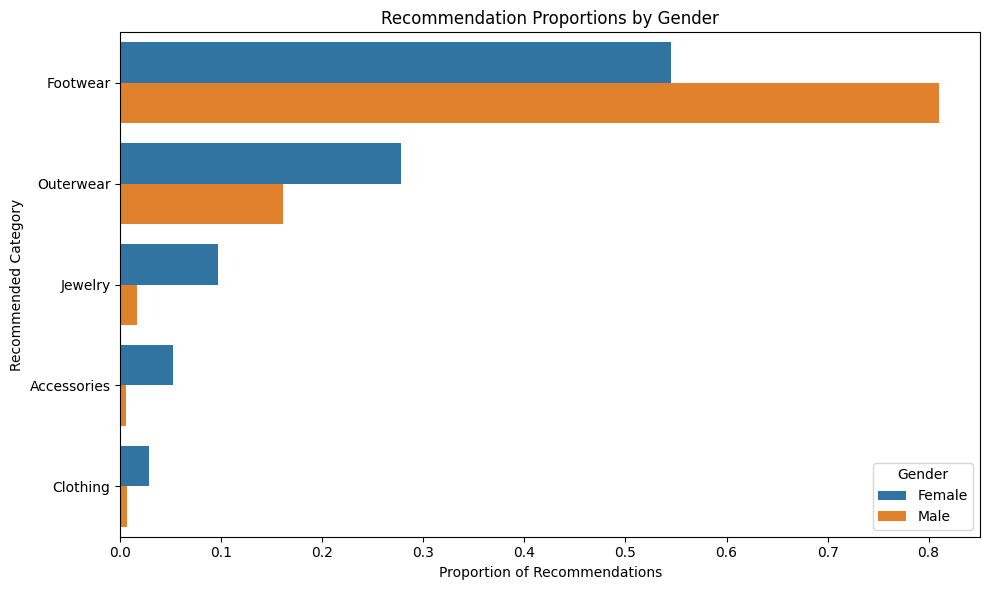

In [1]:
# -*- coding: utf-8 -*-
"""Welcome To Colab

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/notebooks/intro.ipynb
"""

!pip install stable-baselines3
!pip install fairlearn
import pandas as pd
import numpy as np
from stable_baselines3 import PPO
from fairlearn.metrics import MetricFrame # This line was causing the error
from fairlearn.metrics import demographic_parity_difference
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io

import pandas as pd
import numpy as np
from stable_baselines3 import PPO
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io

# Step 1: Upload the preprocessed data file manually in Google Colab
def load_preprocessed_data():
    print("Please upload the 'preprocessed_shopping_data.csv' file.")
    uploaded = files.upload()

    target_file = None
    for filename in uploaded.keys():
        if 'preprocessed_shopping_data' in filename.lower():
            target_file = filename
            break

    if target_file is None:
        print("Error: No file containing 'preprocessed_shopping_data' was found in uploaded files.")
        return None

    try:
        df = pd.read_csv(io.BytesIO(uploaded[target_file]))
        print(f"Preprocessed data loaded from '{target_file}' with shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# Step 2: Load the trained PPO model
def load_model(model_path='ppo_shopping_model'):
    try:
        model = PPO.load(model_path)
        print("Model loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Step 3: Simulate recommendations using the RL model
def simulate_recommendations(model, data):
    feature_cols = [col for col in data.columns if col != 'Customer ID' and 'Purchase Amount (USD)' not in col]
    category_mapping = {i: cat for i, cat in enumerate(['Clothing', 'Footwear', 'Outerwear', 'Accessories', 'Jewelry'])}

    recommendations = []
    for idx in range(len(data)):
        obs = data.iloc[idx][feature_cols].values.astype(np.float32)
        action, _ = model.predict(obs, deterministic=True)
        action_scalar = int(action.item())
        recommended_category = category_mapping[action_scalar]
        recommendations.append(recommended_category)

    return recommendations

# Step 4: Evaluate fairness using fairlearn
def evaluate_fairness(data, recommendations):
    data['Recommendation'] = recommendations
    sensitive_features = data['Gender_Male'].map({1: 'Male', 0: 'Female'})

    def recommendation_proportion(y_true, y_pred):
        return pd.Series(y_pred).value_counts(normalize=True).to_dict()

    mf = MetricFrame(
        metrics=recommendation_proportion,
        y_true=data['Recommendation'],
        y_pred=data['Recommendation'],
        sensitive_features=sensitive_features
    )

    print("\nRecommendation distribution by Gender:")
    print(mf.by_group)

    dpd = demographic_parity_difference(
        y_true=data['Recommendation'] == 'Clothing',
        y_pred=data['Recommendation'] == 'Clothing',
        sensitive_features=sensitive_features
    )
    print(f"\nDemographic Parity Difference for 'Clothing' recommendations: {dpd:.3f}")
    print("(Lower values indicate better fairness across groups)")

    return mf.by_group

# Step 5: Visualize fairness metrics
def visualize_fairness(mf_by_group):
    # Expand the dictionaries in mf.by_group into a DataFrame
    fairness_data = []
    for gender, proportions in mf_by_group.items():
        for category, proportion in proportions.items():
            fairness_data.append({'Gender': gender, 'Category': category, 'Proportion': proportion})

    fairness_data = pd.DataFrame(fairness_data)

    # Plot the recommendation proportions by gender
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Proportion', y='Category', hue='Gender', data=fairness_data)
    plt.title('Recommendation Proportions by Gender')
    plt.xlabel('Proportion of Recommendations')
    plt.ylabel('Recommended Category')
    plt.tight_layout()
    plt.savefig('fairness_plot.png')
    files.download('fairness_plot.png')
    plt.show()

# Main function
def main():
    df = load_preprocessed_data()
    if df is None:
        return

    model = load_model()
    if model is None:
        return

    recommendations = simulate_recommendations(model, df)
    fairness_metrics = evaluate_fairness(df, recommendations)
    visualize_fairness(fairness_metrics)

if __name__ == "__main__":
    main()